# Installation

In [2]:
!pip install micrograd

# Example Usage

In [3]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b ** 3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0/f

print(f"Value of a : {a}")
print(f"Value of b : {b}")
print(f"Value of c : {c}")
print(f"Value of d : {d}")
print(f"Value of e : {e}")
print(f"Value of f : {f}")
print(f"Value of g : {g}\n")

print(f"{g.data:.4f}")  # prints 24.7041, the outcome of this forward pass.
g.backward() # gradient of "g" respect to the each variable is being called.
print(f"{a.grad:.4f}") # the numerical value of dg/da
print(f"{b.grad:.4f}") # numerical value of dg/db

# that shit is tellin us, how g's value will changed if you tweak the value of "A" or "B"

Value of a : Value(data=-4.0, grad=0)
Value of b : Value(data=2.0, grad=0)
Value of c : Value(data=-1.0, grad=0)
Value of d : Value(data=6.0, grad=0)
Value of e : Value(data=-7.0, grad=0)
Value of f : Value(data=49.0, grad=0)
Value of g : Value(data=24.70408163265306, grad=0)

24.7041
138.8338
645.5773


dg/da = dg/df * df/de * (de/dc * dc/da + de/dd * dd/da)

dg/db = dg/df * df/de * (de/dc * dc/db + de/dd * dd/db)

dg/dc = dg/df * df/de * de/dc

dg/dd = dg/df * df/de * de/dd


## Writing that whole shit again.

In [4]:
class Value :
    def __init__(self,data,_children=(),_op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op  # operation. yamar operation hiij, ene sdag gargaj avsan gedgiig medehiin tuld.

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+")
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print(d)
print(d._prev , d._op)  # children values-iig shaana. And operation.

Value(data = 4.0)
{Value(data = 10.0), Value(data = -6.0)} +


## Expanding our shit

In [5]:
class Value :
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self.label = label
        self._op = _op


    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+")
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        return out

a = Value(2.0 , label="a")
b = Value(-3.0 , label="b")
c = Value(10.0, label='c')
e = a*b ; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0 , label='f')
L = d*f ; L.label="L"
print(d)
print(d._prev , d._op)  # children values-iig shaana. And operation.

Value(data = 4.0)
{Value(data = 10.0), Value(data = -6.0)} +


## Helper shit for visualising.

In [6]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes :
            nodes.add(v)
            for child in v._prev :
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format="svg" , graph_attr={"rankdir":"LR"}) # LR => left to right

    nodes,edges = trace(root)

    for n in nodes :
        uid = str(id(n))
        dot.node(name=uid,label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad),shape="record")

        if n._op:
            dot.node(name=uid + n._op , label=n._op)
            dot.edge(uid + n._op,uid)

    for n1, n2 in edges :
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

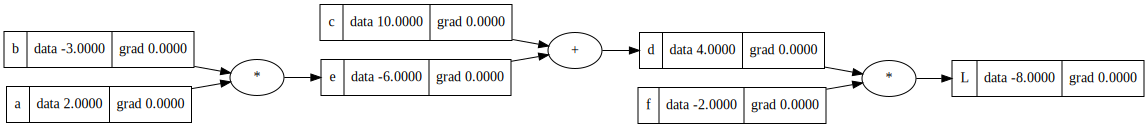

In [7]:
draw_dot(L)

## BackPropagation

In [8]:
class Value :
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self.label = label
        self._op = _op


    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+")
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        return out

a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
d = a*b + c
print(d)
print(d._prev , d._op)

Value(data = 4.0)
{Value(data = -6.0), Value(data = 10.0)} +


In [31]:
def lol():
    h = 0.000111  # enenii too medeej, hed ch baij bolno.
    a = Value(2.0 , label="a")
    b = Value(-3.0 , label="b")
    c = Value(10.0, label='c')
    e = a*b ; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 , label='f')
    L = d*f ; L.label="L"
    L1 = L.data

    a = Value(2.0 , label="a")
    b = Value(-3.0 , label="b")
    c = Value(10.0, label='c')
    e = a*b ; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h  # ene deer l gehed, d deer nemeed ugchij bui ni, derivative of L respect to d, gesen ug. which will be value of f
    f = Value(-2.0 , label='f')
    L = d*f ; L.label="L"
    L2 = L.data

    print((L2-L1)/h)

lol()

-2.000000000007501


L's derivative respect to d  ===> (L2-L1)/h

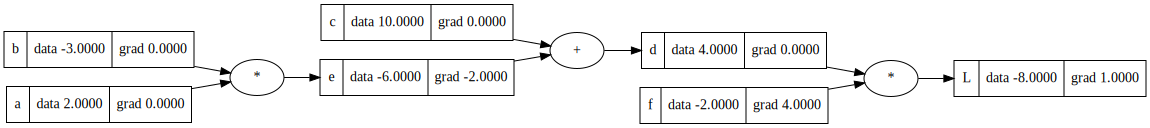

In [10]:
# hervee AIX deereees uzsen shit-ee sanaj baigaa bol,backprop deer, add gate, mul gate geed baisandaa.
# teriig l end ashiglaj baigaan baina. all respect to the L node. since L will our output node thus, loss will be calculated only on the L node.
# tegeed l nemj baigaa uyd, grad ni uurchlugduhgu.
"""

a + b = c bailaa ghed, c-iin derivative respect to the "a" result is 1.
that means chain rule is multiplying local/ upstream gradient just by 1.

but when multiplying, a*b = c
c's derivative respect to the 'a' is 'b'  ... that means multiplying upstream gradient by 'b'

tegeheer, urjij baigaa shit-uud deer bol, nuguu node-nii data.gaar ni cross multiplication.

"""
L.grad = 1.0
d.grad = -2.0
f.grad = 4  # jishee ni upstream buyu l-iin grad-iig d.iin data-gaar urjuuljee l gesen ug.
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

In [11]:
# now let's update the shitsss
# suppose  learning rate is 0.01

a.data += 0.01*a.grad
b.data += 0.01*b.grad
b.data += 0.01*c.grad
f.data += 0.01*f.grad

# e, and d are not being updated, since they would the re-calculated when forward passing again.

e = a*b
d = e+c
L = d*f

# now show the result, after backpropagation happened.
print(L.data)
print(a.data)


-7.244943999999999
2.06


## Bit Mode harder example

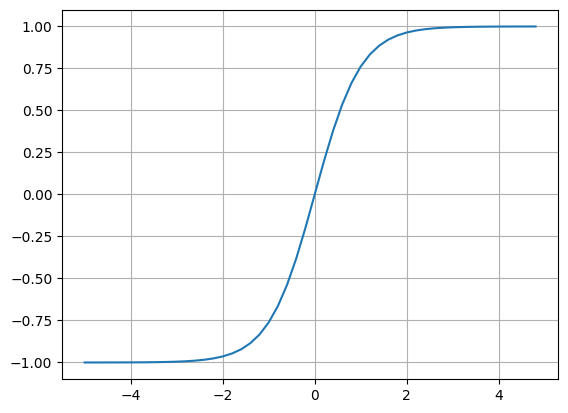

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))) ; plt.grid();

#tanh function makes every points in between -1 and 1

### Updating our Value class yet again

In [13]:
import math

class Value :
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self.label = label
        self._op = _op


    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),"+")
        return out

    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),"*")
        return out

    def tanh(self):
        x = self.data
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        return out

a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
d = a*b + c
print(d)
print(d._prev , d._op)

Value(data = 4.0)
{Value(data = -6.0), Value(data = 10.0)} +


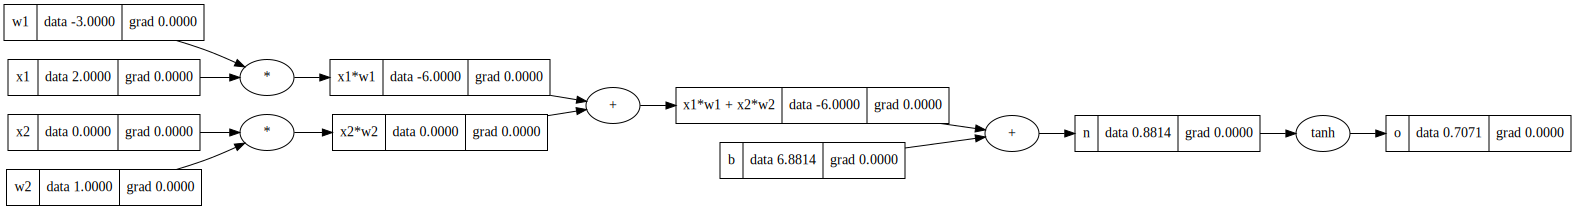

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


draw_dot(o)

In [15]:
# now let's do manual backpropagation.

o.grad = 1.0
#derivative of tanh is 1-tanh^2.meaning -> do/dn => 1-o**2  || since o=tanh
n.grad = 1-o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad

x1.grad = n.grad * w1.data
w1.grad = n.grad * x1.data
x2.grad = n.grad * w2.data
w2.grad = n.grad * x2.data

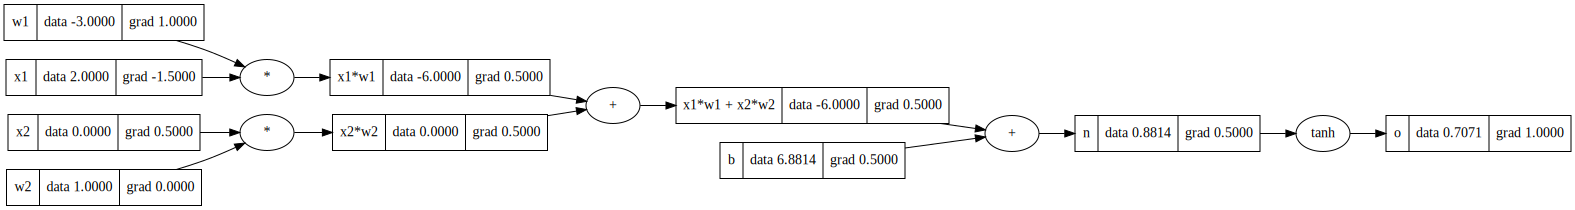

In [16]:
# here is the updated shit.
draw_dot(o)

# Now it is time for creating our final Value class

In [17]:
import math

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad  # backward calculates its children neuron's gradients using current gradient for it. and since we're just doing additional operation in here,children and parent gradient will remain same.
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    # Fallback operations for symmetry

    # odoo ene heden function-iig bol yurn fallback kinda shits gej oilgo. yagaad gevel umnu , a * 2 gevel ajillah ch gesen , 2 * a gevel shaahgu. yagad gevel other , self bolood, eniig hande hiideg shit bid nart umnu ni baigaagui

    def __neg__(self):               # -self
        return self * -1

    def __radd__(self, other):       # other + self
        return self + other

    def __sub__(self, other):        # self - other
        return self + (-other)

    def __rsub__(self, other):       # other - self
        return other + (-self)

    def __rmul__(self, other):       # other * self
        return self * other

    def __truediv__(self, other):    # self / other
        return self * other ** -1

    def __rtruediv__(self, other):   # other / self
        return other * self ** -1


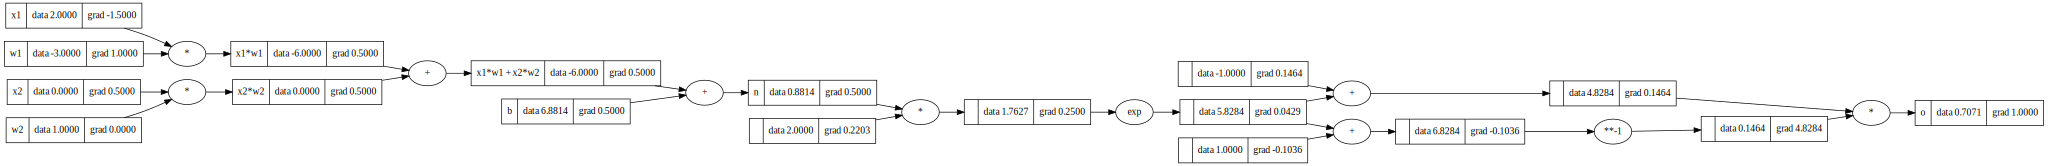

In [18]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1)/ (e+1)

o.label = 'o'
o.backward()  # see? now just this function can do rest of our job.
draw_dot(o)

# Creating Neuron, Layer Class etc.

### Neuron Class

In [19]:
import random
class Neuron :
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):

        act = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        """
        for wi, xi in zip(self.w, x):
            print(f"w: {wi.data}, x: {xi}, w*x: {(wi*xi).data}")
            """
        return act

x = [2.0,3.0]
n = Neuron(2)
n(x)  # 2 neurons 2inputs shaaj baigaa ch gesen sum return hiij baigaa tul gants l result avjin.

Value(data=2.705316068387873, grad=0.0)

### Layer Class

In [20]:
class Layer :  # ene deer bol heden yur ni heden neurontoi layer uusgehee shiidne gehiimuda.? input , bolon output-iig shiidej ugdug shit baina.
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs

x = [2.0,3.0]
n = Layer(2,3)
n(x)

[Value(data=0.7497293715779776, grad=0.0),
 Value(data=-3.4614868865805564, grad=0.0),
 Value(data=-0.3465186583312907, grad=0.0)]

###MLP

In [21]:
class MLP : # ene deer bol heden input, heden neuron-toi layer, heden output, gargahaa bugdiig ni shaaj ugch baina.
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers :
            x = layer(x)
        return x

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

[Value(data=0.4982636783112293, grad=0.0)]

In [22]:
# odoo neg halti train maygiin yum shaaj uzetsgeey!
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

y_pred = [n(x)[0] for x in xs]
y_pred

[Value(data=0.4982636783112293, grad=0.0),
 Value(data=3.0591381132545354, grad=0.0),
 Value(data=1.865666879019443, grad=0.0),
 Value(data=0.9758336556579458, grad=0.0)]

In [23]:
loss = sum([(yout - ygt)**2 for ygt , yout in zip(ys,y_pred)])

loss


Value(data=24.940972232685265, grad=0.0)

In [24]:
n.layers[0].neurons[0].w

[Value(data=-0.4402456502574983, grad=0.0),
 Value(data=-0.7013782855619519, grad=0.0),
 Value(data=-0.26608037539415674, grad=0.0)]

In [25]:
loss.backward()
n.layers[0].neurons[0].w

[Value(data=-0.4402456502574983, grad=32.85268897888268),
 Value(data=-0.7013782855619519, grad=-7.109243569234295),
 Value(data=-0.26608037539415674, grad=14.1543763573003)]

## Putting it all together

In [26]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [27]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])

len(n.parameters())

41

In [28]:
# odoo neg halti train maygiin yum shaaj uzetsgeey!
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

y_pred = [n(x) for x in xs]

loss = sum([(yout - ygt)**2 for ygt , yout in zip(ys,y_pred)])

print(loss)

loss.backward()


AttributeError: 'Value' object has no attribute 'tanh'

In [ ]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [ ]:
y_pred = [n(x) for x in xs]

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))

print(loss)  # now you can see that loss is going down.

In [ ]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # zero gradients
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    p.grad = 0.0
    loss.backward()

    # update weights

    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


In [ ]:
y_pred = [n(x) for x in xs]
y_pred